In [28]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1

# from blackwater.data.utils import (
#     generate_random_pauli_sum_op,
#     create_estimator_meas_data,
#     circuit_to_graph_data_json,
#     get_backend_properties_v1,
#     encode_pauli_sum_op,
#     create_meas_data_from_estimators
# )

from mlp import MLP1, MLP2, MLP3, encode_data

#from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors

In [29]:
from mlp import recursive_dict_loop, count_gates_by_rotation_angle

In [30]:
from mbd_utils import calc_imbalance

In [31]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [32]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [33]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise(backend=backend).add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

random seed fixed to 0
thetas [0.06896594 0.08987335 0.07574548 0.06847204 0.05323803 0.08116545
 0.05498883 0.1120635 ]


In [34]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_no_readout = RemoveReadoutErrors().remove_readout_errors()[0]

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}

# no measurement errors 
run_config_noisy_no_readout = {'shots': 10000, 'backend': backend_noisy_no_readout, 'name': 'noisy_no_readout'}

num_qubit = 4

`load_circuits` loads the qiskit quantum circuit objects and also the `ideal_exp_vals` and the `noisy_exp_vals` from the .pk files. These circuits are premade, no idea yet how they created them but probably same thing like with ngem could work.

In [35]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files[1:], leave=True):
        #print(data_file)
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [36]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/14 [00:00<?, ?it/s]

4200


  0%|          | 0/14 [00:00<?, ?it/s]

1400


In [37]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals_input]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals_input]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [38]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [39]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [40]:
X_train_noisy_only = pd.DataFrame(X_train).iloc[:, -4:]
X_train_without_noisy = pd.DataFrame(X_train).iloc[:, :-4]

In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(X_train_without_noisy, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list_only_noisy = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list_only_noisy.append(rfr)

In [43]:
# with open('./model/ising_init_from_qasm_no_readout/rfr_list.pk', 'wb') as f:
#     pickle.dump(rfr_tree_list, f)

random seed fixed to 0
RMSE_noisy_0: 0.06550247099813064
RMSE_mitigated_0: 0.0513109878388795
RMSE_noisy_1: 0.05991942535795197
RMSE_mitigated_1: 0.03973212707761156
RMSE_noisy_2: 0.1703969244030019
RMSE_mitigated_2: 0.07588178920758175
RMSE_noisy_3: 0.06290111600237397
RMSE_mitigated_3: 0.02233883831337924
RMSE_noisy: 0.101084832544792
RMSE_mitigated: 0.05115791489507827


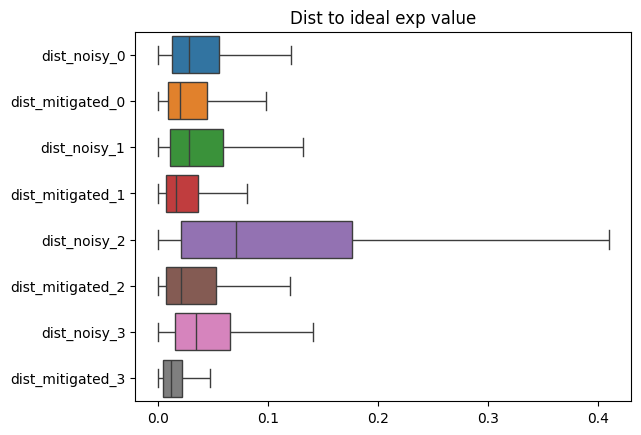

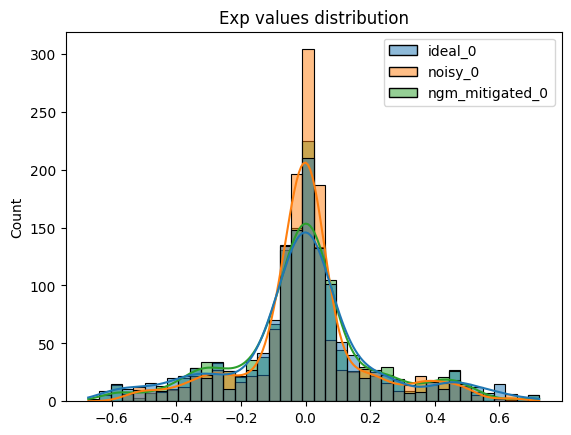

In [44]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        rfr_tree_list_result = model.predict(pd.DataFrame(batch_X[:, :]).iloc[:, :-4])
        rfr_tree_list_noisy_result = rfr_tree_list_only_noisy[q].predict(pd.DataFrame(batch_X[:, :]))
        preds = (rfr_tree_list_result + rfr_tree_list_noisy_result)/2
        out.append(preds)
    out = np.array(out).transpose()
    #print(out)
    # out = rfr.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0] #hm?
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [45]:
rfr_tree_list_importances = []

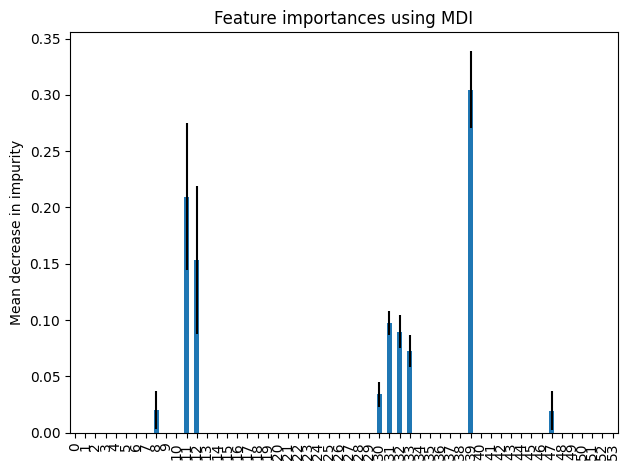

In [46]:
forest = rfr_tree_list[0]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

features = []
for i in range(len(importances)):
    features.append(i)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [47]:
rfr0_importances = []
for i in range(len(forest_importances)):
    if forest_importances[i] > 0: rfr0_importances.append((i, forest_importances[i]))
rfr_tree_list_importances.append(rfr0_importances)

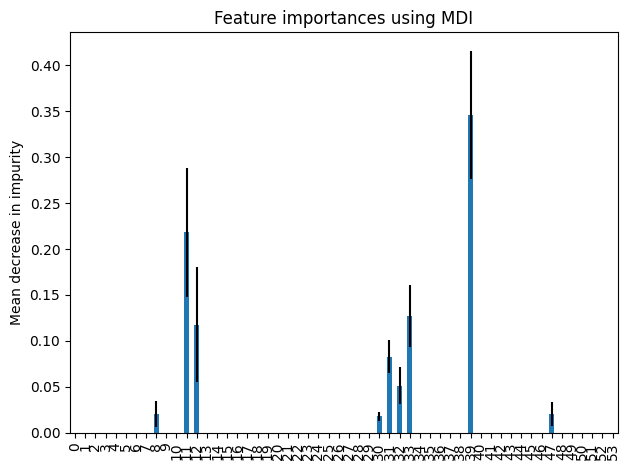

In [48]:
forest = rfr_tree_list[1]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

features = []
for i in range(len(importances)):
    features.append(i)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [49]:
rfr1_importances = []
for i in range(len(forest_importances)):
    if forest_importances[i] > 0: rfr1_importances.append((i, forest_importances[i]))
rfr_tree_list_importances.append(rfr1_importances)

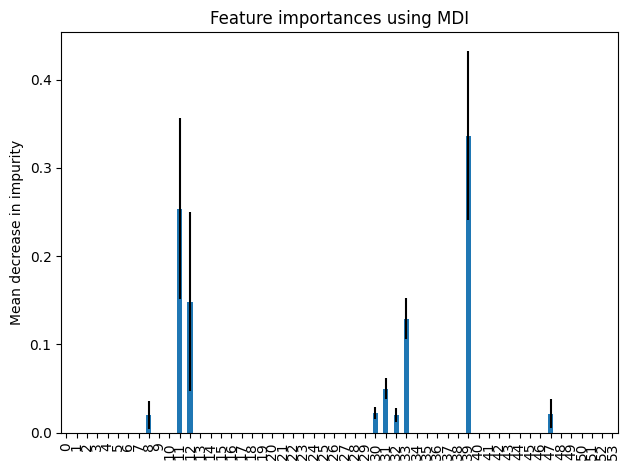

In [50]:
forest = rfr_tree_list[2]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

features = []
for i in range(len(importances)):
    features.append(i)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [51]:
rfr2_importances = []
for i in range(len(forest_importances)):
    if forest_importances[i] > 0: rfr2_importances.append((i, forest_importances[i]))
rfr_tree_list_importances.append(rfr2_importances)

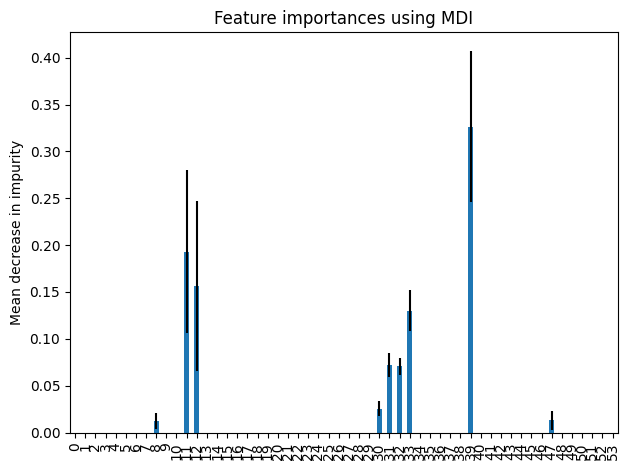

In [52]:
forest = rfr_tree_list[3]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

features = []
for i in range(len(importances)):
    features.append(i)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [53]:
rfr3_importances = []
for i in range(len(forest_importances)):
    if forest_importances[i] > 0: rfr3_importances.append((i, forest_importances[i]))
rfr_tree_list_importances.append(rfr3_importances)